In [1]:
# 训练模型
## 快速训练和测试：xgboost训练
## 提取训练特征集
## 并按照0.8 ： 0.2比例分割训练集和测试集
from sklearn.model_selection import train_test_split
import xgboost as xgb
###  把训练集进行分隔成训练集，验证集，测试集

In [2]:
import pandas as pd
import os
import math      
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
import time
import warnings 
import seaborn as sns 
warnings.filterwarnings('ignore') 

In [3]:
B_data=pd.read_csv("../../dataSet/GT3X-V2.8-00/Bdata.csv",  index_col="Unnamed: 0")
T_data=pd.read_csv("../../dataSet/GT3X-V2.8-00/Tdata.csv",  index_col="Unnamed: 0")

In [4]:
B_data.head()

,Component ID,Volume(%),Height(um),Area(%),OffsetX(mm),OffsetY(mm),Result,Panel
0,1:C2,98.832,106.662,92.660,0.005,0.000,1,1.0
1,1:C2,95.402,100.189,95.222,0.000,0.000,1,1.0
2,1:C10,103.047,111.748,92.214,-0.011,0.007,1,1.0
3,1:C10,105.500,117.418,89.850,0.000,0.007,1,1.0
4,1:C11,103.741,117.714,88.129,-0.008,-0.006,1,1.0


In [5]:
B_data.isnull().sum()

Component ID    0
Volume(%)       0
Height(um)      0
Area(%)         0
OffsetX(mm)     0
OffsetY(mm)     0
Result          0
Panel           0
dtype: int64

In [6]:
B_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6557880 entries, 0 to 6559432
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Component ID  object 
 1   Volume(%)     float64
 2   Height(um)    float64
 3   Area(%)       float64
 4   OffsetX(mm)   float64
 5   OffsetY(mm)   float64
 6   Result        int64  
 7   Panel         float64
dtypes: float64(6), int64(1), object(1)
memory usage: 450.3+ MB


#### 切分数据集

In [7]:
x = B_data[["Volume(%)","Height(um)","Area(%)" , "OffsetX(mm)" ,"OffsetY(mm)" ]]
y = B_data.loc[:,B_data.columns == 'Result']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

In [17]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

from sklearn.metrics import roc_auc_score,roc_curve,auc
param = {'n_estimators': 500,
         'max_depth': 4, 
         'min_child_weight': 3,
         'gamma':0.3,
         'subsample': 0.8,
         'colsample_bytree': 0.8,  
         'eta': 0.125,
         'silent': 1, 
         'objective': 'binary:logistic',
         'eval_metric':'auc',
         'nthread':16
        }
evallist = [(dtrain, 'train'),(dtest,'test')]
bst = xgb.train(param, dtrain, 500,evallist, early_stopping_rounds=10)


##使用测试集，评估模型
x_test_DMatrix = xgb.DMatrix(x_test)
y_pred = bst.predict(x_test_DMatrix)

## 调用ROC-AUC函数，计算其AUC值
roc_auc_score(y_test,y_pred) 

[14:29:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:29:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-auc:0.98601	test-auc:0.98295
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 10 rounds.
[1]	train-auc:0.98745	test-auc:0.98450
[2]	train-auc:0.98826	test-auc:0.98441
[3]	train-auc:0.98847	test-auc:0.98463
[4]	train-auc:0.98852	test-auc:0.98473

0.9995759954054155

In [21]:
y_test.value_counts()

Result
1         1311294
0             282
dtype: int64

In [25]:
y_pred

array([0.9999962 , 0.9999951 , 0.99999666, ..., 0.99999595, 0.9999969 ,
       0.9999931 ], dtype=float32)

<AxesSubplot:ylabel='Density'>

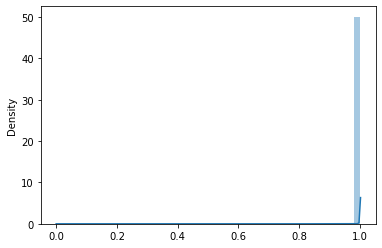

In [27]:
sns.distplot(y_pred)

In [51]:
def pre_class(map_data):
    if map_data>0.7:
        return 1
    else:
        return 0

In [52]:
l=[]
for i in y_pred:
    l.append(pre_class(i))

In [53]:
from sklearn.metrics import confusion_matrix
classes = list(set(y_test))
confusion = confusion_matrix(y_test,l) 

Text(33.0, 0.5, 'true')

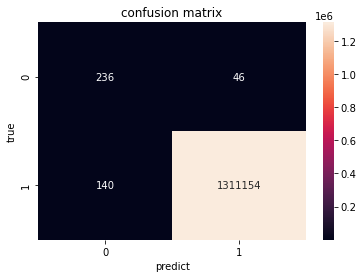

In [54]:
ax = sns.heatmap(pd.DataFrame(confusion),annot=True,fmt='.20g')
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #yconfusion

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test,l))

              precision    recall  f1-score   support

           0       0.63      0.84      0.72       282
           1       1.00      1.00      1.00   1311294

    accuracy                           1.00   1311576
   macro avg       0.81      0.92      0.86   1311576
weighted avg       1.00      1.00      1.00   1311576



# 建立模型

使用不同的模型、查看模型的效果

#### 1、逻辑回归

In [11]:
B_data.head()

,Component ID,Volume(%),Height(um),Area(%),OffsetX(mm),OffsetY(mm),Result,Panel
0,1:C2,98.832,106.662,92.660,0.005,0.000,1,1.0
1,1:C2,95.402,100.189,95.222,0.000,0.000,1,1.0
2,1:C10,103.047,111.748,92.214,-0.011,0.007,1,1.0
3,1:C10,105.500,117.418,89.850,0.000,0.007,1,1.0
4,1:C11,103.741,117.714,88.129,-0.008,-0.006,1,1.0


In [10]:
B_data.value_counts("Component ID")

Component ID
1:D6     2377620
1:D5     2237760
1:D8      186480
1:D9      124320
1:D4       77700
1:Q2       62160
1:VT4      46620
1:VT3      46620
1:R46      31080
1:R45      31080
1:R30      31080
1:R31      31080
1:R32      31080
1:R33      31080
1:R34      31080
1:R35      31080
1:R36      31080
1:R4       31080
1:R40      31080
1:VD7      31080
1:R50      31080
1:R49      31080
1:R28      31080
1:R48      31080
1:R41      31080
1:R42      31080
1:R43      31080
1:R44      31080
1:R29      31080
1:C10      31080
1:R27      31080
1:C55      31080
1:C12      31080
1:C13      31080
1:C18      31080
1:C2       31080
1:C20      31080
1:C25      31080
1:C43      31080
1:C50      31080
1:C51      31080
1:C56      31080
1:R26      31080
1:L7       31080
1:Q1       31080
1:R14      31080
1:R15      31080
1:R16      31080
1:R18      31080
1:R2       31080
1:C11      31080
1:R25      31080
1:R24      31080
dtype: int64

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

stdScaler=StandardScaler()
X=stdScaler.fit_transform()

TypeError: fit_transform() missing 1 required positional argument: 'X'